In [1]:
%matplotlib inline
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, StratifiedKFold, train_test_split
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from scipy import interp

In [2]:
def rf_pf_predictions(RF_inputs, PF_inputs, phenotype = ''):  
    # Figure
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    
    # RF
    X_train = RF_inputs['X_train']
    X_test = RF_inputs['X_test']
    y_train = RF_inputs['y_train']
    y_test = RF_inputs['y_test']
    estimator = RF_inputs['estimator']    
    paramgrid = RF_inputs['paragrid']
    
    for params in paramgrid:
        #aucs = []
        model = estimator(**params)
        
        model.fit(X_train, y_train)
        probas = model.predict_proba(X_test)

        precision, recall, _ = precision_recall_curve(y_test, probas[:,1])
 
        ap_value1 = average_precision_score(y_test, probas[:,1])            
    
        ax.step(recall, precision, color='steelblue',
                label='RandomForest PRC, AP: {0:0.2f}'.format(ap_value1),
                lw=2, alpha=.8)

    # PF
    y_test = PF_inputs['y_test']
    y_probas = PF_inputs['y_probas']
    
    precision, recall, _ = precision_recall_curve(y_test, y_probas)

    ap_value2 = average_precision_score(y_test, y_probas)

    ax.step(recall, precision, color='orange',
            label='PhyloFactor PRC, AP: {0:0.2f}'.format(ap_value2),
            lw=2, alpha=.8)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])

    ax.set_title('Precision-Recall curve: {}'.format(phenotype))
    ax.legend(loc="best")
    
    yield ax, model

# RF Data

MODIFY THE PATH OF Microbiome-Factorization

In [3]:
ROOT = "/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Knight/Microbiome-Factorization/"

In [4]:
train_OTUs_filename = ROOT + "/outputs/train_filtered_OTUs_table.tsv"
test_OTUs_filename = ROOT + "/outputs/test_filtered_OTUs_table.tsv"

train_MetaData_filename = ROOT + "/outputs/train_filtered_metadata.txt"
test_MetaData_filename = ROOT + "/outputs/test_filtered_metadata.txt"

In [5]:
X_train = pd.read_csv(train_OTUs_filename, sep='\t', index_col='#OTU ID')
X_test = pd.read_csv(test_OTUs_filename, sep='\t', index_col='#OTU ID')

In [6]:
y_train = pd.read_csv(train_MetaData_filename, sep='\t', index_col='#SampleID')
y_test = pd.read_csv(test_MetaData_filename, sep='\t', index_col='#SampleID')

# PF Data

In [7]:
PF_DATA_FOLDER = ROOT + '/outputs/PhyloFactor/'
DATA_TYPE = '16S_'

# Phenotypes to evaluate

In [8]:
OUTPUT_FOLDER = ROOT + '/outputs/'

In [9]:
columns = ['PhClasses',
          ]

phenotypes = {'PhClasses' : 'pH'}

# Analyze both models

processing PhClasses
16S_PhClasses.png


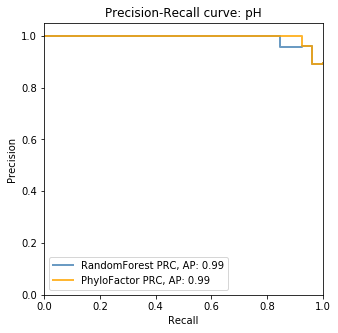

In [10]:
errored = []
models = dict()


for col in columns:
    print('processing %s' % col)

    # Random Forest
    train = X_train.copy()
    test = X_test.copy()
    mf_train = y_train.copy()
    mf_test = y_test.copy()

    labels_train = pd.to_numeric(mf_train[col], errors='coerce')
    labels_train.dropna(inplace=True)
    train = train.loc[:,list(labels_train.index)]
    
    labels_test = pd.to_numeric(mf_test[col], errors='coerce')
    labels_test.dropna(inplace=True)
    test = test.loc[:,list(labels_test.index)]

    RF_inputs = dict()
    RF_inputs['X_train'] = train.T.values
    RF_inputs['X_test'] = test.T.values
    RF_inputs['y_train'] = labels_train.values
    RF_inputs['y_test'] = labels_test.values
    RF_inputs['estimator'] = RandomForestClassifier
    RF_inputs['paragrid'] = [{'n_estimators':1000, 'n_jobs':4}]
    RF_inputs['cv'] = StratifiedKFold(2)
    
    # PhyloFactor
    
    table = pd.read_csv(PF_DATA_FOLDER+DATA_TYPE+col+".csv")
    
    PF_inputs = dict()
    PF_inputs['y_test'] = table['True']
    PF_inputs['y_probas'] = table['Predicted']
    
    AX = rf_pf_predictions(RF_inputs, PF_inputs, phenotype = phenotypes[col])
    
    
    # Predictions and Figures
    ax, models[col] = next(AX)

    output = DATA_TYPE + col + '_PR-Curve.png'
    print(output)
    
    plt.savefig(OUTPUT_FOLDER + output, dpi=326)

## Random Forest Features Importance

In [11]:
taxonomy_filename = ROOT + "/data/GreenGenes/97_otu_taxonomy.txt"
taxonomy = pd.read_csv(taxonomy_filename, sep='\t', header=None)
taxonomy.columns = ['ID', 'Taxonomy']
taxonomy.set_index('ID', inplace=True)

16S_PhClasses_RF-Features.png


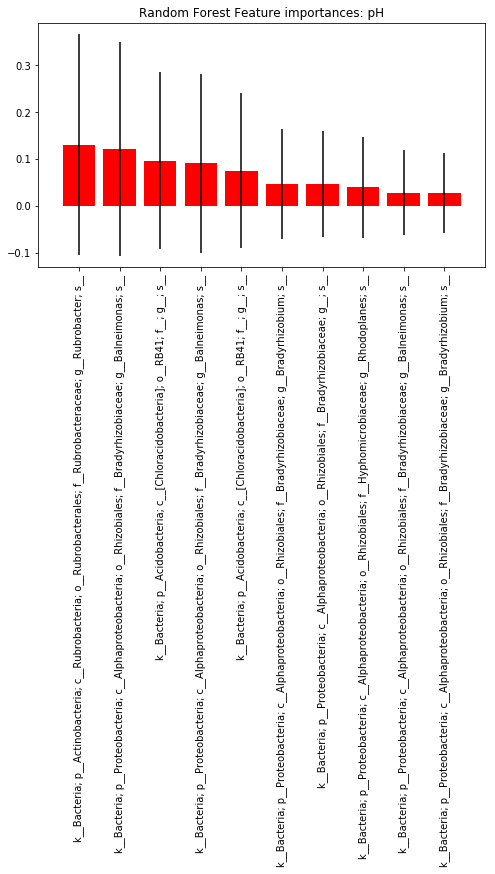

In [12]:
for col in columns:
    forest = models[col]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    
    # Sort
    indices = np.argsort(importances)[::-1]
    
    # Top 5:
    top = indices[:10]
    names = np.array(X_train.index)[top]
    tax = taxonomy.loc[names, 'Taxonomy'].values
    
    fig = plt.figure(figsize=(8, 4.5))
    plt.title("Random Forest Feature importances: {}".format(phenotypes[col]))
    plt.bar(range(len(names)), importances[top],
           color="r", yerr=std[top], align="center")
    plt.xticks(range(len(names)), tax, rotation=90)
    plt.xlim([-1, len(names)])
    
    # Save fig
    
    output = DATA_TYPE + col + '_RF-Features.png'
    print(output)
    plt.savefig(OUTPUT_FOLDER + output, dpi=326, bbox_inches='tight')